In [1]:
import pandas as pd
import pickle
df_seoul = pd.read_pickle('seoul_신한카드.pkl')
df_dong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 행정동코드', skiprows=1)
df_upjong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 업종코드', skiprows=1)
df_upjong_code = df_upjong_code[['업종코드 (32개 분류)']]
df_upjong_code.dropna(inplace=True)

In [2]:
pd.options.display.float_format = '{:.1f}'.format

In [3]:
df_seoul[df_seoul['행정동코드']==520]

,기준일자,행정동코드,업종코드,성별코드,나이코드,이용건수,이용금액,건별 이용금액
구코드,,,,,,,,
140,20190201,520,10,F,20,14,1038,74.1
140,20190201,520,10,F,25,59,4635,78.6
140,20190201,520,10,F,30,41,3046,74.3
140,20190201,520,10,F,35,59,5995,101.6
140,20190201,520,10,F,40,45,5172,114.9
...,...,...,...,...,...,...,...,...
140,20200531,520,81,M,45,28,277,9.9
140,20200531,520,81,M,50,9,117,13.0
140,20200531,520,81,M,55,14,342,24.4


In [4]:
df_dong_code = df_dong_code[:34]

In [5]:
import re
upjong_dic={}
gu_dic={}
dong_dic={}
for i,j in zip(df_dong_code['구코드'], df_dong_code['구명']):
    gu_dic[i]=j
for i,j in zip(df_dong_code['행정동코드'], df_dong_code['행정동명']):
    dong_dic[i]=j
for i in df_upjong_code.values:
    key = re.findall('\((.*)\)',i[0])[0]
    val = re.findall('(.*)\(',i[0])[0]
    upjong_dic[key]=val

In [6]:
#type 바꿔주기
df_seoul['기준일자'] = df_seoul['기준일자'].astype(str)
df_seoul['기준일자'] = pd.to_datetime(df_seoul['기준일자'])
df_seoul['업종코드'] = df_seoul['업종코드'].astype(str)

#시구, 동, 업종코드 mapping
df_seoul['시_구'] = df_seoul.index.map(gu_dic)
df_seoul['행정동'] = df_seoul['행정동코드'].map(dong_dic)
df_seoul['업종'] = df_seoul['업종코드'].map(upjong_dic)

In [7]:
df_seoul['Year'] = df_seoul['기준일자'].dt.year
df_seoul['Month'] = df_seoul['기준일자'].dt.month

구별 (업종별, 성별, 나이별, (이용금액,건수))
140:중구, 350:노원구

In [8]:
df_seoul['행정동코드'].unique()

array([520, 540, 550, 570, 580, 590, 605, 615, 625, 635, 645, 650, 665,
       670, 680, 560, 595, 600, 611, 612, 619, 621, 624, 630, 640, 695,
       700, 710, 720], dtype=int64)

In [9]:
df_set={}

In [10]:
df_0 = df_seoul[['시_구','업종','Year','이용건수','이용금액']].groupby(['시_구','업종','Year']).mean()

In [11]:
df_1 = df_seoul.query('업종 in [ "요식업소", "레저업소", "숙박", "의복", "유통업"]')
df_1 = df_1[['시_구','행정동','업종','Year','Month','이용건수','이용금액']].groupby(['시_구','행정동','Month','업종','Year']).mean()

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
def gu_dong(gu, dong):
    for m in df_seoul.Month.unique():
        if m == 2:
            df_2 = df_1.loc[gu,dong,m].T
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new = pd.DataFrame(a)
            df_new.columns = ['2월']
            df_new
        else : 
            df_2 = df_1.loc[gu,dong,m].T
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new['{}월'.format(m)] = a
    df_new = df_new.stack().reset_index()
    df_new.columns = ['업종','월','전년대비_변화율']
    a = sns.barplot(data = df_new, x = '업종', y = '전년대비_변화율', hue='월')
    plt.title(dong, {'fontsize' : 25, 'color':'black'})
    for index, row in df_new.iterrows():
        a.text((row['업종',row['월'])row['전년대비_변화율'],round(row['전년대비_변화율'],1), color='black', ha="center")
    a.plot
    
    return df_new.set_index(['업종','월'])

SyntaxError: invalid syntax (<ipython-input-41-380a5e60b0ea>, line 20)

KeyError: ('업종', '월')

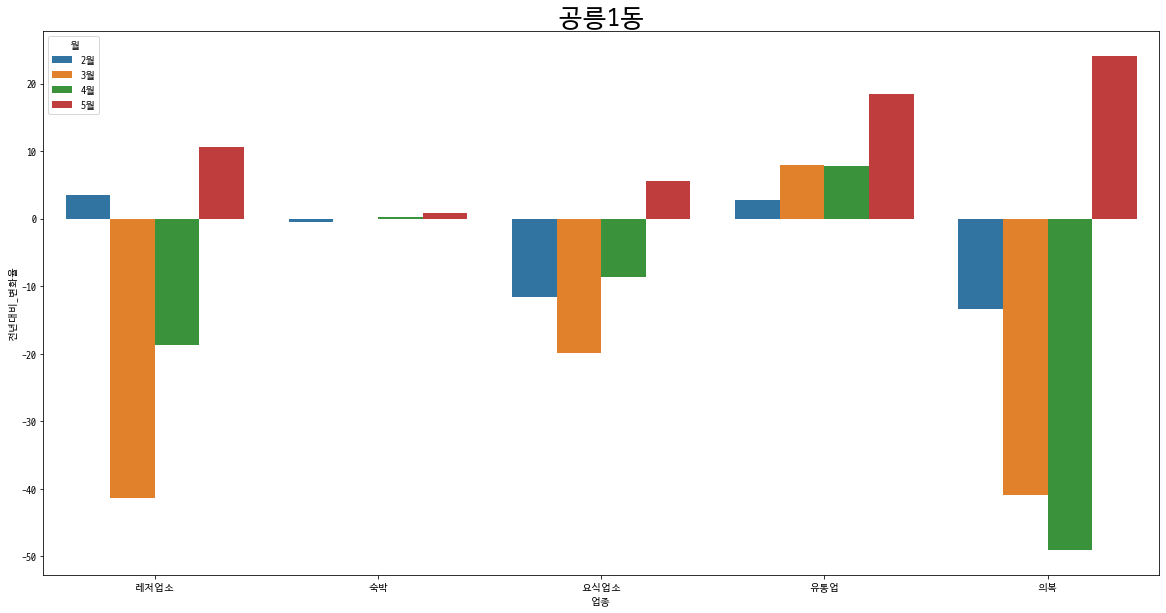

In [42]:
plt.rcParams['figure.figsize'] = [20,10]
gu_dong('서울 노원구','공릉1동')

In [239]:
df_new

,업종,월,전년대비_변화율
0,가구,2월,-6.061999
1,가구,3월,21.221400
2,가구,4월,-108.873475
3,가구,5월,-129.519996
4,가전,2월,21.479938
...,...,...,...
87,주방용구,5월,5.074661
88,직물,2월,32.428609
89,직물,3월,-22.173047
90,직물,4월,-43.919950


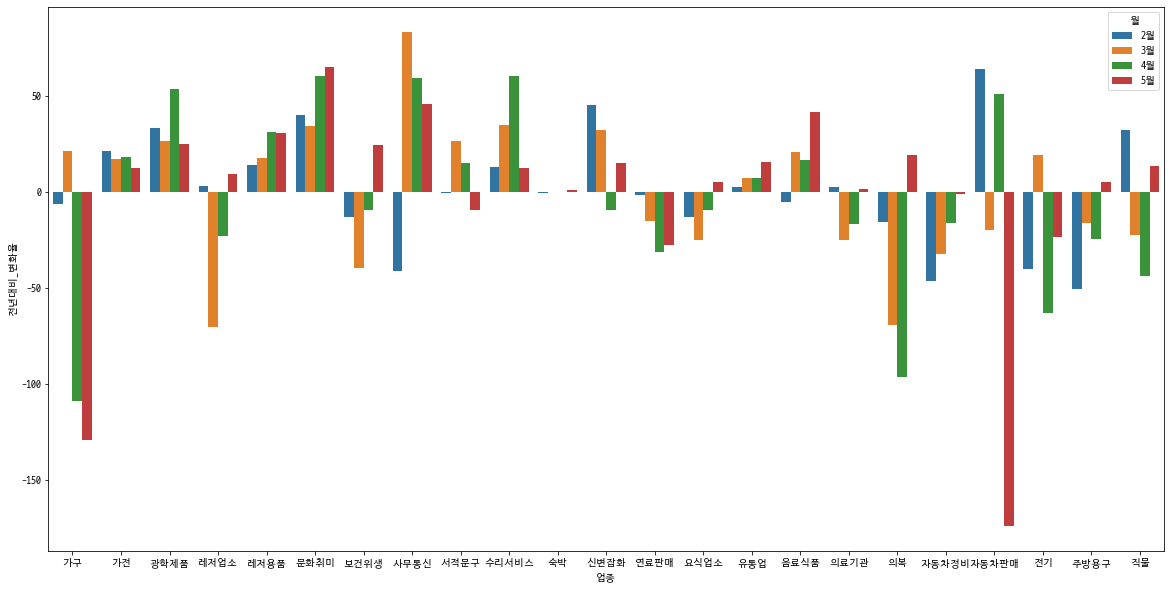

# 노원구 중구의 코로나 이전(2019)과 이후(2020) 업종별 이용건수 이용금액 추이

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

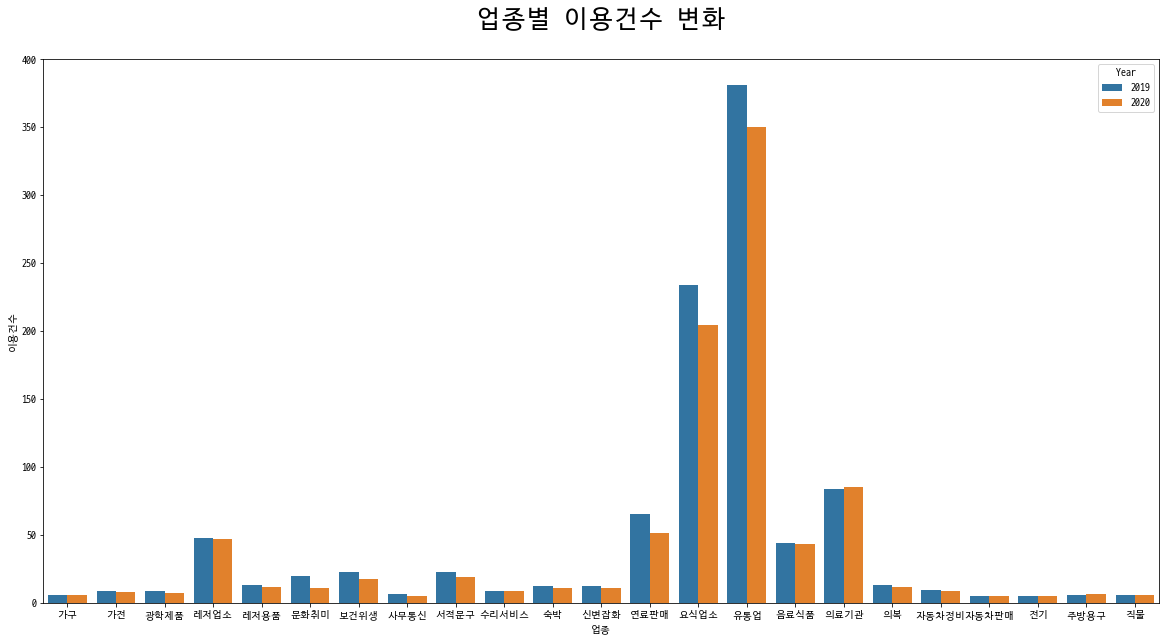

In [283]:

plt.rcParams['figure.figsize'] = [20,10]
g1 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용건수',hue='Year', ci=None)
plt.title('업종별 이용건수 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

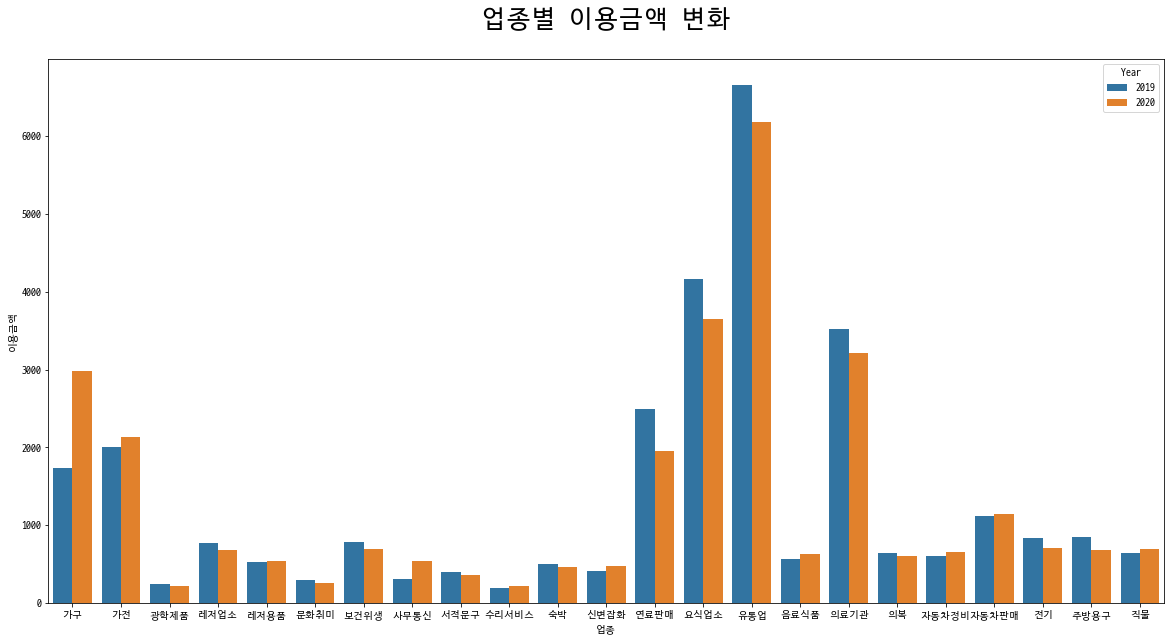

In [284]:
g2 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)
plt.title('업종별 이용금액 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

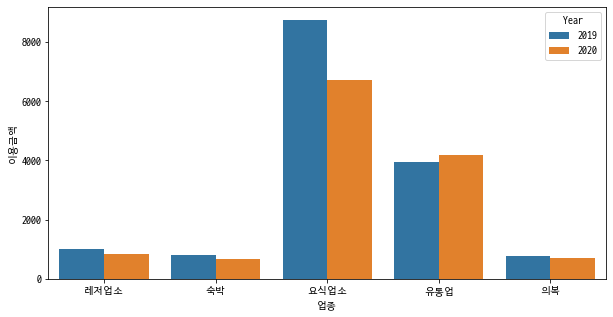

In [338]:
g3 = sns.barplot(data = df_1.loc['서울 노원구','상계6.7동'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

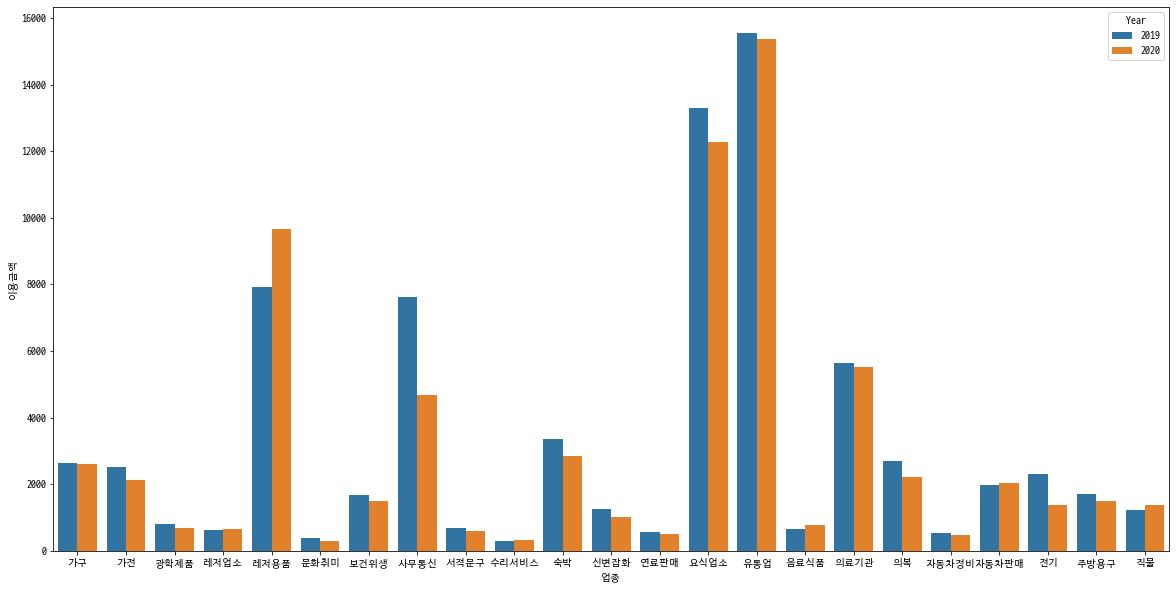

In [52]:
g3 = sns.barplot(data = df_0.loc['서울 중구',5].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

In [125]:
df_set['동별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['행정동','기준일자'],as_index=True).sum()[['이용건수','이용금액']]
df_set['업종별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['업종','기준일자'],as_index=True).sum()[['이용건수','이용금액']]

---

In [346]:
import pandas as pd
import pickle
df_corona = pd.read_csv('modeling/data/서울시 확진자 현황.csv', encoding='ANSI')

In [352]:
df_corona.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,3867,8.30.,19855,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
1,3866,8.30.,19897,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
2,3865,8.30.,19900,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
3,3864,8.30.,19788,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
4,3863,8.30.,19797,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y


In [360]:
df_corona['접촉력'].value_counts()[:30].to_csv('abcd.csv', encoding='cp949')

서울시 확진자 중 감염경로라고 볼수 있는 접촉력에대해 보면 밀집된 장소에서 주로 감염이 되었다고 볼수있다.
-> 밀집된장소는 위험하다, 피해야한다